

**Machine Learning I (Semester 1 2024)**
# Tutorial Session 7: Classification

*N. Hernitschek*



This Jupyter notebook is the first of a series around classification methods.

It is based on code from the textbook

*An Introduction to Statistical Learning: with Applications in Python.*
James Witten, Hastie, Tibshirani; Springer.

which is vailable for free as PDF: https://www.statlearning.com/

It also contains code from http://www.biostathandbook.com/simplelogistic.html


***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Logistic Regression with `scikit-learn`](#first-bullet)
* [Logistic Regression 3-class Classifier](#second-bullet)




## 1. Logistic Regression with `scikit-learn` <a class="anchor" id="first-bullet"></a>



### Importing Packages

We start with importing some of our libraries:

In [4]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns

### Example 1

Show in the plot is how the logistic regression would, in this synthetic dataset, classify values as either 0 or 1, i.e. class one or two, using the logit-curve.

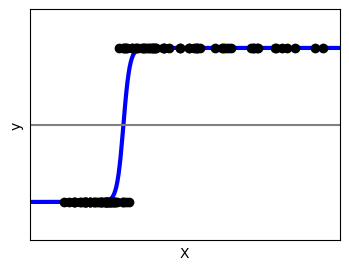

In [51]:
# Code source: Gael Varoquaux
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

# test data set: straight line with some Gaussian noise
xmin, xmax = -5, 5
n_samples = 100
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0)
X[X > 0] *= 4
X += 0.3 * np.random.normal(size=n_samples)

X = X[:, np.newaxis]
# run the classifier
clf = linear_model.LogisticRegression(C=1e5) #regularization, standard value
clf.fit(X, y)

# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)


def model(x):
    return 1 / (1 + np.exp(-x))

linreg = model(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, linreg, color='blue', linewidth=3)

ols = linear_model.LinearRegression()
ols.fit(X, y)
plt.axhline(0.5, color='0.5')

plt.ylabel('y')
plt.xlabel('X')
plt.xticks(())
plt.yticks(())
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)

plt.show()

### Example 2

The following data are from Suzuki et al. (2006): Sand grain size in an area vs. whether certain spiders are present or absent in that area.


In [5]:
data = """Grain size (mm)	Spiders
0.245	absent
0.247	absent
0.285	present
0.299	present
0.327	present
0.347	present
0.356	absent
0.36	present
0.363	absent
0.364	present
0.398	absent
0.4	present
0.409	absent
0.421	present
0.432	absent
0.473	present
0.509	present
0.529	present
0.561	absent
0.569	absent
0.594	present
0.638	present
0.656	present
0.816	present
0.853	present
0.938	present
1.036	present
1.045	present
"""
df = pd.read_table(io.StringIO(data))
df.Spiders = df.Spiders == 'present'
df.head()


,Grain size (mm),Spiders
0,0.245,False
1,0.247,False
2,0.285,True
3,0.299,True
4,0.327,True


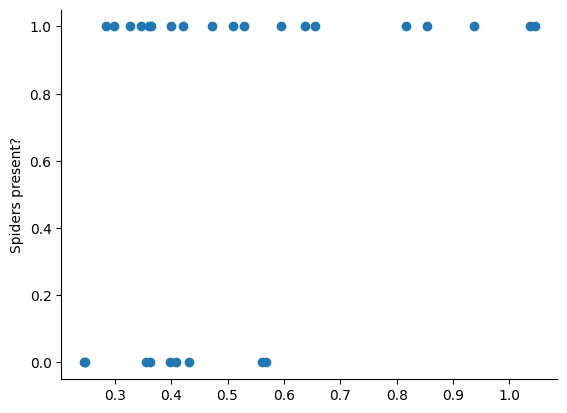

In [19]:
plt.scatter(df['Grain size (mm)'], df['Spiders'])
plt.ylabel('Spiders present?')
sns.despine()

We will now analyze these data using the `scikit-learn` package.


In [21]:
import sklearn.linear_model

`scikit-learn` has a logisitic regression classifier which uses regularization. To eliminate regularization, we set the regularization parameter C to $10^{12}$.

<font color='red'>Task: Try it out later on with regularization.</font> 

In [29]:
#df['Grain size (mm)'].reshape(-1, 1)

# C=1e12 is effectively no regularization - see https://github.com/scikit-learn/scikit-learn/issues/6738
clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(df['Grain size (mm)'].values.reshape(-1, 1), df['Spiders'])
print(clf.intercept_, clf.coef_)


[-1.64761964] [[5.12153717]]


In [30]:
def plot_log_reg(x, y, data, clf, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(data[x], data[y], color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax, 300)

    loss = scipy.special.expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.tight_layout()
    sns.despine()
    return fig, ax

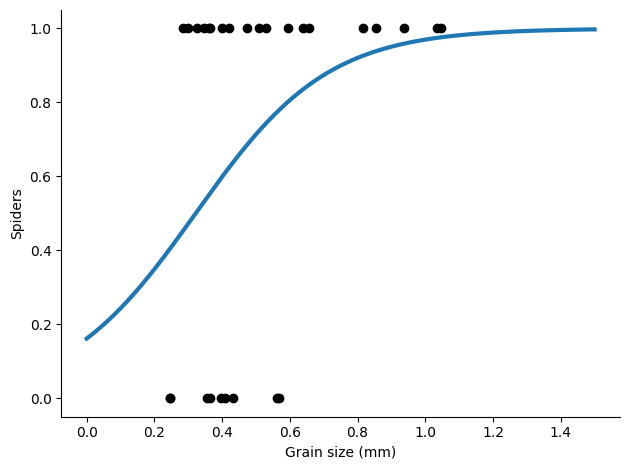

In [31]:

plot_log_reg(x='Grain size (mm)', y='Spiders', data=df, clf=clf, xmin=0, xmax=1.5);

#### Hypothesis testing

To test if `Grain size` is a significant factor, we use the likelihood ratio test.

We calculate the likelihood of the model with the grain size (the alternative model):


In [32]:
def log_reg_null_model(y):
    clf = sklearn.linear_model.LogisticRegression(C=1e12)
    clf.fit(np.zeros_like(y).reshape(-1, 1), y)
    return clf

clf0 = log_reg_null_model(df['Spiders'])

The likelihood ratio test operates by calculating the test statistic D from the likelihoods of the null and alternative models: 

$$ D = -2 \log \frac{L(H_0)}{L(H_1)}$$

 The test statistic is then approximately chisquare distributed.
 
 scikit-learn has a log-loss function that can help us do that. The log-loss is defined as the negative log-likelihood, so we can rewrite:
D=2(−logL(H0)+logL(H1))⇒D=2(logloss(H0)−logloss(H1))


In [33]:
import sklearn.metrics

In [36]:


def log_reg_lik_ratio_test(X, Y, clf0, clf1, df=1):
    if X.ndim == 1:
        X = X.values.reshape(-1, 1)
    y_prob0 = clf0.predict_proba(X)
    loss0 = sklearn.metrics.log_loss(Y, y_prob0, normalize=False)
    y_prob1 = clf1.predict_proba(X)
    loss1 = sklearn.metrics.log_loss(Y, y_prob1, normalize=False)
    D = 2 * (loss0 - loss1)
    return scipy.stats.distributions.chi2.sf(D, df=df)



In [37]:
log_reg_lik_ratio_test(df['Grain size (mm)'], df['Spiders'].astype(np.float64), clf0, clf)

0.03324376680911948



## 2. Logistic Regression 3-class Classifier <a class="anchor" id="second-bullet"></a>


We can also use logistic regression as a classifier when we have more than 2 classes.


### The Iris Dataset


As an example of a simple dataset, we take a look at the iris data set. It is a commonly used example data set for machine learning algorithms. The data consists of measurements of three different species of iris flowers.

The data come from measurements made in Quebec by botanist Dr. Edgar Anderson and first used for Sir Ronald Fisher's 1936 [classification paper](http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf), see [https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set).


### Loading the Iris Data with Scikit-Learn

Scikit-learn has a very straightforward set of data on these iris species.  The data consist of
the following:

- **Features/attributes in the Iris dataset:**
  1. sepal length in cm
  2. sepal width in cm
  3. petal length in cm
  4. petal width in cm
  
  (The petal is the colorful "leaf" of a flower. The sepal is the green "leaf" at the bottom of a flower.)

Scikit-learn refers to the "labels" as "targets".  So, every time you see "target", just think "label" and it will make more sense.  
- **The target classes are:**
  1. Iris Setosa
  2. Iris Versicolour
  3. Iris Virginica
  
``Scikit-Learn`` embeds a copy of the iris CSV file along with a helper function to load it into numpy arrays:

In [56]:
from sklearn import datasets

iris = datasets.load_iris()



`iris` is a dictionary, so we can look at the "keys" of the dictionary as follows:

In [57]:
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


* `target_names` were defined above
* `data` is the `[n_samples, n_features]` data array
* `target` is the list of labels for all of the entries in `data`
* `DESCR` is a README file with all of the information about the data set
* `feature_names` were defined above

In [58]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

We can query the database to determine the shape of the data and find that there are 150 objects with 4 measurements each:

In [59]:
print(iris.data.shape)
n_samples, n_features = iris.data.shape
print(n_samples, n_features)

(150, 4)
150 4


Now let's look at both the first entry in `data` and the full $N\times M$ data array. The first entry shows the values of the 4 features for the first object.

Note the structure of the full data array: It is an `n_samples` array of arrays with `n_features`.  Scikit-learn requires this exact format which isn't always what you would generate naturally (particulary in the case where we have only one feature).

In [60]:
print(iris.data[0])
print(iris.data)

[5.1 3.5 1.4 0.2]
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5

### Scatter Plot of the Iris dataset

This data is four-dimensional, so it's not easy to visualize. But we can visualize two of the dimensions
at a time using a simple scatter-plot.




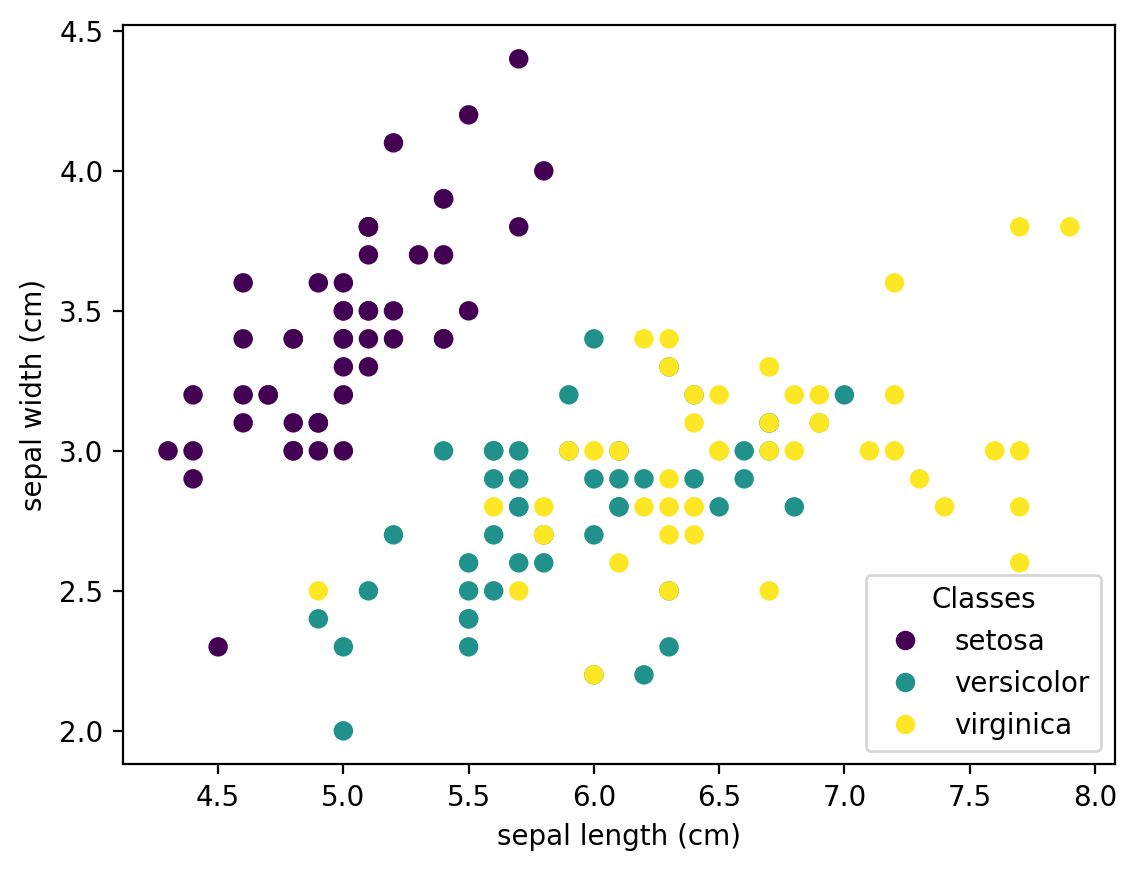

In [64]:

import numpy as np

import matplotlib.pyplot as plt
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

Each point in the scatter plot refers to one of the 150 iris flowers in the dataset, with the color indicating their respective type (Setosa, Versicolour, and Virginica). You can already see a pattern regarding the Setosa type, which is easily identifiable based on its short and wide sepal. Only considering these 2 dimensions, sepal width and length, there’s still overlap between the Versicolor and Virginica types.

### Carrying out a 3-classLogistic Regression


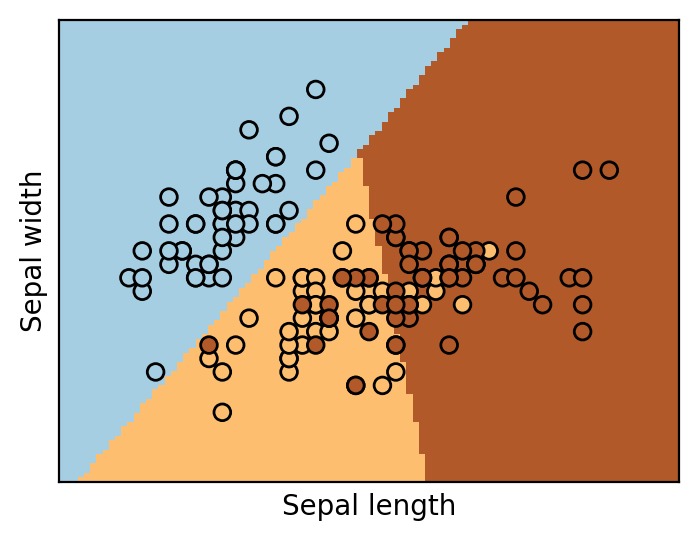

In [66]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

_, ax = plt.subplots(figsize=(4, 3))
DecisionBoundaryDisplay.from_estimator(
    logreg,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="Sepal length",
    ylabel="Sepal width",
    eps=0.5,
)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)


plt.xticks(())
plt.yticks(())

plt.show()


## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how to carry out logistic regression for binary classification (two classes)
* seen an example of logistic regression for 3 or more classes, including plots that make sense in this situation.